# Training LSTM on residuals of physical model

In [56]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from itertools import product
from tqdm.auto import tqdm


# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from ode_model import LorenzModel
from lstm import WindowedTimeSeries, train_model, predict_autoregressive, evaluate_model

In [57]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

Generate data
- 10,000 obs
- noise proportion (observed data)= 0.05
- noise proportion (assimilate data) = 0.01

In [58]:
n = 10000
noise_level = 0.05
assim_noise_level=0.01
time_step = 0.05

data = generate_data(n, noise_level=noise_level, time_step=time_step)
assimilated_data = generate_data(n, noise_level=assim_noise_level, time_step=time_step)

In [4]:
data.shape

(10000, 3)

Create imperfect Lorenz Model
- Set c = 12.5 (MSE LSTM aprrox = LSTM ODE for k=10)

In [59]:
ode_model = LorenzModel(c=13)

Predict k steps ahead using ODE model
- Compute residuals and inspect

In [6]:
k=10
ode_model.update_params(t_step = k*time_step)
preds_ode = ode_model.predict(y0=assimilated_data)
true = data
residuals_ode = true[k: , :] - preds_ode[:-k, :]

In [7]:
residuals_ode.shape

(9990, 3)

In [8]:
np.mean(residuals_ode ** 2)

7.5761576987510795

In [9]:
residuals_ode.std(axis=0, ddof=1)

array([3.49602548, 2.49133325, 2.06371061])

In [ ]:
plt.plot(residuals_ode[:,2])
plt.show()

Train LSTM
- Split data into train and test
- convert data to custom class
- Train LSTM

In [10]:
input_series = data[:-k, ]
input_series.shape

(9990, 3)

In [11]:
train_length = int(residuals_ode.shape[0] * 0.8)
val_length = int(residuals_ode.shape[0] * 0.9)
train_target_series = residuals_ode[:train_length, :]
val_target_series = residuals_ode[train_length:val_length, :]
test_target_series = residuals_ode[val_length:, :]
train_input_series = input_series[:train_length, :]
val_input_series = input_series[train_length:val_length, :]
test_input_series = input_series[val_length:, :]


In [13]:
train_dataset = WindowedTimeSeries(train_input_series, train_target_series, seq_length=10)
val_dataset = WindowedTimeSeries(val_input_series, val_target_series, seq_length=10)
test_dataset = WindowedTimeSeries(test_input_series, test_target_series, seq_length=10)

In [14]:
lstm_model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=256,
  learning_rate=0.01,
  num_epochs=20,
  device=device
)

Epoch [10/20], train_loss: 1.0862, val_loss: 1.2026
Epoch [20/20], train_loss: 0.9786, val_loss: 0.9805


In [15]:
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [20]:
mse = evaluate_model(lstm_model, test_dataset)
print(f"MSE: {mse}")

MSE: 0.9670098423957825


In [32]:
c_range = np.linspace(11,16,11)
# k_range = [1,5,10,15,20]
k_range = np.arange(1,21)

configs = list(product(k_range, c_range))

In [25]:
ds = xr.Dataset(
    {
        "mse": (( "k", "c"),
                np.full((len(k_range), len(c_range)), np.nan))
    },
    coords={
        "k": k_range,
        "c": c_range
    }
)

In [ ]:

pbar = tqdm(configs, desc="Hyperparameter Sweep", colour="green")


for k, c in pbar:
  ode_model.update_params(c=c, t_step=k*0.05)
  preds_ode = ode_model.predict(y0=assimilated_data)
  true = data[:-k,]

  residuals_ode = data[k: , :] - preds_ode[:-k, :]

  train_length = int(residuals_ode.shape[0] * 0.8)
  val_length = int(residuals_ode.shape[0] * 0.9)
  train_target_series = residuals_ode[:train_length, :]
  val_target_series = residuals_ode[train_length:val_length, :]
  test_target_series = residuals_ode[val_length:, :]
  train_input_series = true[:train_length, :]
  val_input_series = true[train_length:val_length, :]
  test_input_series = true[val_length:, :]

  train_dataset = WindowedTimeSeries(input_series=train_input_series, target_series=train_target_series, seq_length=10)
  val_dataset = WindowedTimeSeries(input_series=val_input_series, target_series=val_target_series, seq_length=10)
  test_dataset = WindowedTimeSeries(input_series=test_input_series, target_series=test_target_series, seq_length=10)

  lstm_model = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    hidden_size=100,
    num_layers=1,
    batch_size=256,
    learning_rate=0.01,
    num_epochs=200,
    patience=20,
    silence=True,
    device=torch.device("mps")
  )

  mse = evaluate_model(lstm_model, test_dataset)
  ds["mse"].loc[dict(k=k, c=c)] = mse

  pbar.set_postfix(mse=f"{mse:.2f}", k=k, c=c)


Hyperparameter Sweep:   0%|          | 0/220 [00:00<?, ?it/s]

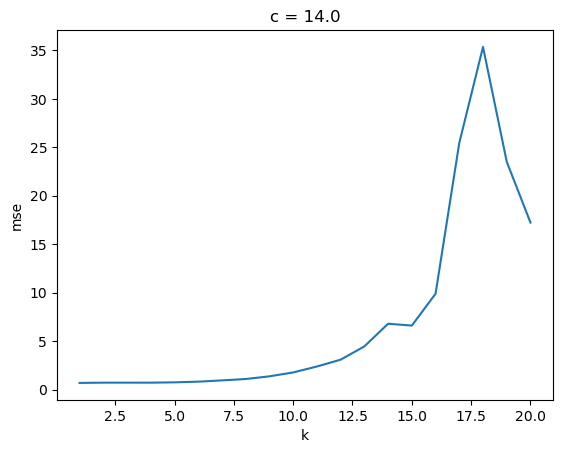

In [54]:
ds["mse"].sel(c=14).plot()

In [55]:
ds.attrs["epochs"] = 100
ds.attrs["patience"] = 20

In [ ]:
out_path = Path("../data/processed/mse_boosted_model2.nc")


ds.to_netcdf(out_path)

# Boosting over range of hidden sizes

In [30]:
c_range = np.linspace(11,16,11)
hidden_sizes = np.arange(2,42,2)
k_range = [5,10,15]
configs = list(product(hidden_sizes, k_range, c_range))

In [31]:
ds = xr.Dataset(
    {
        "mse": (("hidden_size", "k", "c"),
                np.full((len(hidden_sizes), len(k_range), len(c_range)), np.nan))
    },
    coords={
        "hidden_size": hidden_sizes,
        "k": k_range,
        "c": c_range
    }
)

In [32]:
pbar = tqdm(configs, desc="Hyperparameter Sweep", colour="lightgreen")


for h, k, c in pbar:

  ode_model.update_params(c=c)
  preds_ode = ode_model.predict(y0=assimilated_data, t_step=time_step*k)
  true = data[:-k,]

  residuals_ode = data[k: , :] - preds_ode[:-k, :]

  train_length = int(residuals_ode.shape[0] * 0.8)
  val_length = int(residuals_ode.shape[0] * 0.9)
  train_target_series = residuals_ode[:train_length, :]
  val_target_series = residuals_ode[train_length:val_length, :]
  test_target_series = residuals_ode[val_length:, :]
  train_input_series = true[:train_length, :]
  val_input_series = true[train_length:val_length, :]
  test_input_series = true[val_length:, :]

  train_dataset = WindowedTimeSeries(train_input_series, train_target_series, 10)
  val_dataset = WindowedTimeSeries(val_input_series, val_target_series, 10)
  test_dataset = WindowedTimeSeries(test_input_series, test_target_series, 10)

  device = torch.device("mps") if h >= 25 else torch.device("cpu")

  lstm_model = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    hidden_size=int(h),
    num_layers=1,
    batch_size=256,
    learning_rate=0.01,
    num_epochs=100,
    patience=20,
    silence=True,
    device=device
  )

  mse = evaluate_model(lstm_model, test_dataset)
  ds["mse"].loc[dict(hidden_size=h, k=k, c=c)] = mse

  pbar.set_postfix(mse=f"{mse:.2f}", h=h, k=k, c=c)


Hyperparameter Sweep:   0%|          | 0/660 [00:00<?, ?it/s]

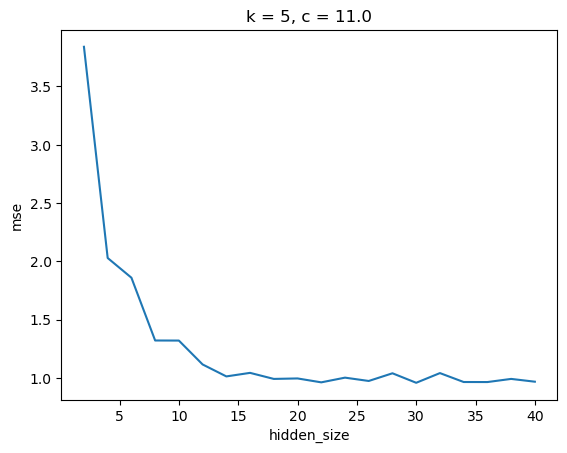

In [35]:
ds["mse"].sel(k=5, c=11).plot()

In [36]:
out_path = Path("../data/processed/mse_boosted_model_h-range.nc")

ds.attrs["patience"] = 20
ds.attrs["epochs"] = 100

ds.to_netcdf(out_path)

# Boosted Model over range of data sized

In [60]:
c_range = np.linspace(11,16,11)
k_range = [5,10,15]
data_size_range = np.arange(100,2001,100)
configs = list(product(k_range, data_size_range, c_range))

In [61]:
ds = xr.Dataset(
    {
        "mse": (("k", "data_size", "c"),
                np.full((len(k_range), len(data_size_range), len(c_range)), np.nan))
    },
    coords={
        "k": k_range,
        "data_size": data_size_range,
        "c": c_range
    }
)

In [68]:
pbar = tqdm(configs, desc="Hyperparameter Sweep", colour="green")


for k, size, c in pbar:

  ode_model.update_params(c=c, t_step=time_step*k)
  preds_ode = ode_model.predict(y0=assimilated_data)
  true = data[:-k,]

  residuals_ode = data[k: , :] - preds_ode[:-k, :]

  train_length = int(residuals_ode.shape[0] * 0.4)
  val_length = int(residuals_ode.shape[0] * 0.7)
  train_target_series = residuals_ode[:train_length, :]
  val_target_series = residuals_ode[train_length:val_length, :]
  test_target_series = residuals_ode[val_length:, :]
  train_input_series = true[:train_length, :]
  val_input_series = true[train_length:val_length, :]
  test_input_series = true[val_length:, :]

  train_target_series_short = train_target_series[:size,]
  train_input_series_short = train_input_series[:size,]

  train_dataset = WindowedTimeSeries(input_series=train_input_series_short, target_series=train_target_series_short, seq_length=10)
  val_dataset = WindowedTimeSeries(input_series=val_input_series, target_series=val_target_series, seq_length=10)
  test_dataset = WindowedTimeSeries(input_series=test_input_series, target_series=test_target_series, seq_length=10)

  lstm_model = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    hidden_size=100,
    num_layers=1,
    batch_size=256,
    learning_rate=0.01,
    num_epochs=300,
    patience=300,
    silence=True,
    device=torch.device("mps")
  )

  mse = evaluate_model(lstm_model, test_dataset)
  ds["mse"].loc[dict(data_size=size, k=k, c=c)] = mse

  pbar.set_postfix(mse=f"{mse:.2f}", data_size=size, k=k, c=c)

Hyperparameter Sweep:   0%|          | 0/660 [00:00<?, ?it/s]

KeyboardInterrupt: 

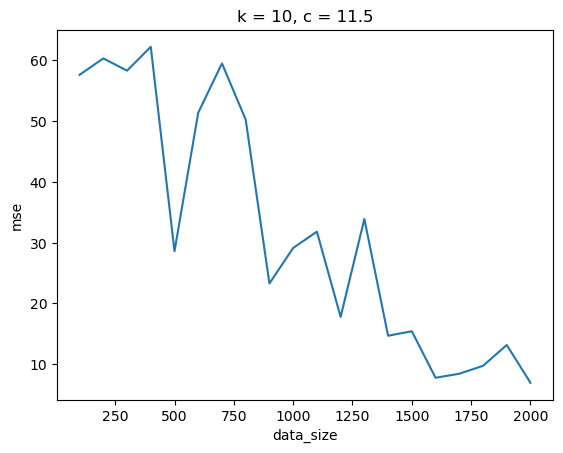

In [66]:
ds["mse"].sel(k=10, c=11.5).plot()

In [ ]:
out_path = Path("../data/processed/mse_boosted_d-range2.nc")

ds.attrs["patience"] = 300
ds.attrs["epcohs"] = 300
ds.attrs["test_size"] = 3000

ds.to_netcdf(out_path)

